Nama  : Ramanda Ajisaka Asyraf

NPM   : 20312067

Kelas : IF 19 Ex

## **Background remover dengan deeplabv3_resnet101**


---


Terdapat persoalan dimana kita harus memisahkan antara object dengan backgroundnnya.  untuk menyelsaikan permasalahan ini saya menggunakan bantuan model yang sudah ada untuk melakukan removing background adalah deeplabv3_resnet101 [(model)](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/). Selain itu saya menggunakan beberapa library tambahan untuk mengelola gambar diaantaranya cv2, torch, numpy, PIL, torchvision, matplotlib. Untuk lebih jelasnya sebagai gambaran bisa lihat pada gambar ini proses sebelum input dan setelah pemrosesan background removing. Alasan saya menggunakan model deeplabv3_resnet101 karena model ini sudah terlatih jadi saya tidak perlu lagi membuat model sendiri dan melatihanya dimana proses tersebut akan memakan waktu dan mempersulit pekerjaan. 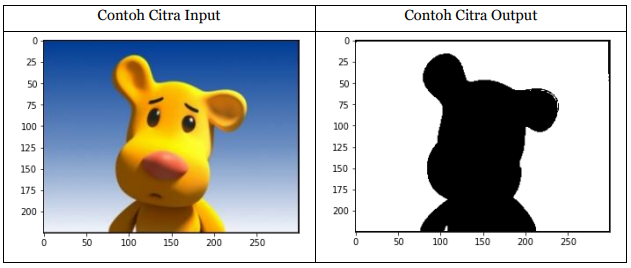



Proses pemecahan masalah dapat dilihat pada baris koding dibawah.


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Text(0.5, 1.0, 'Citra Output')

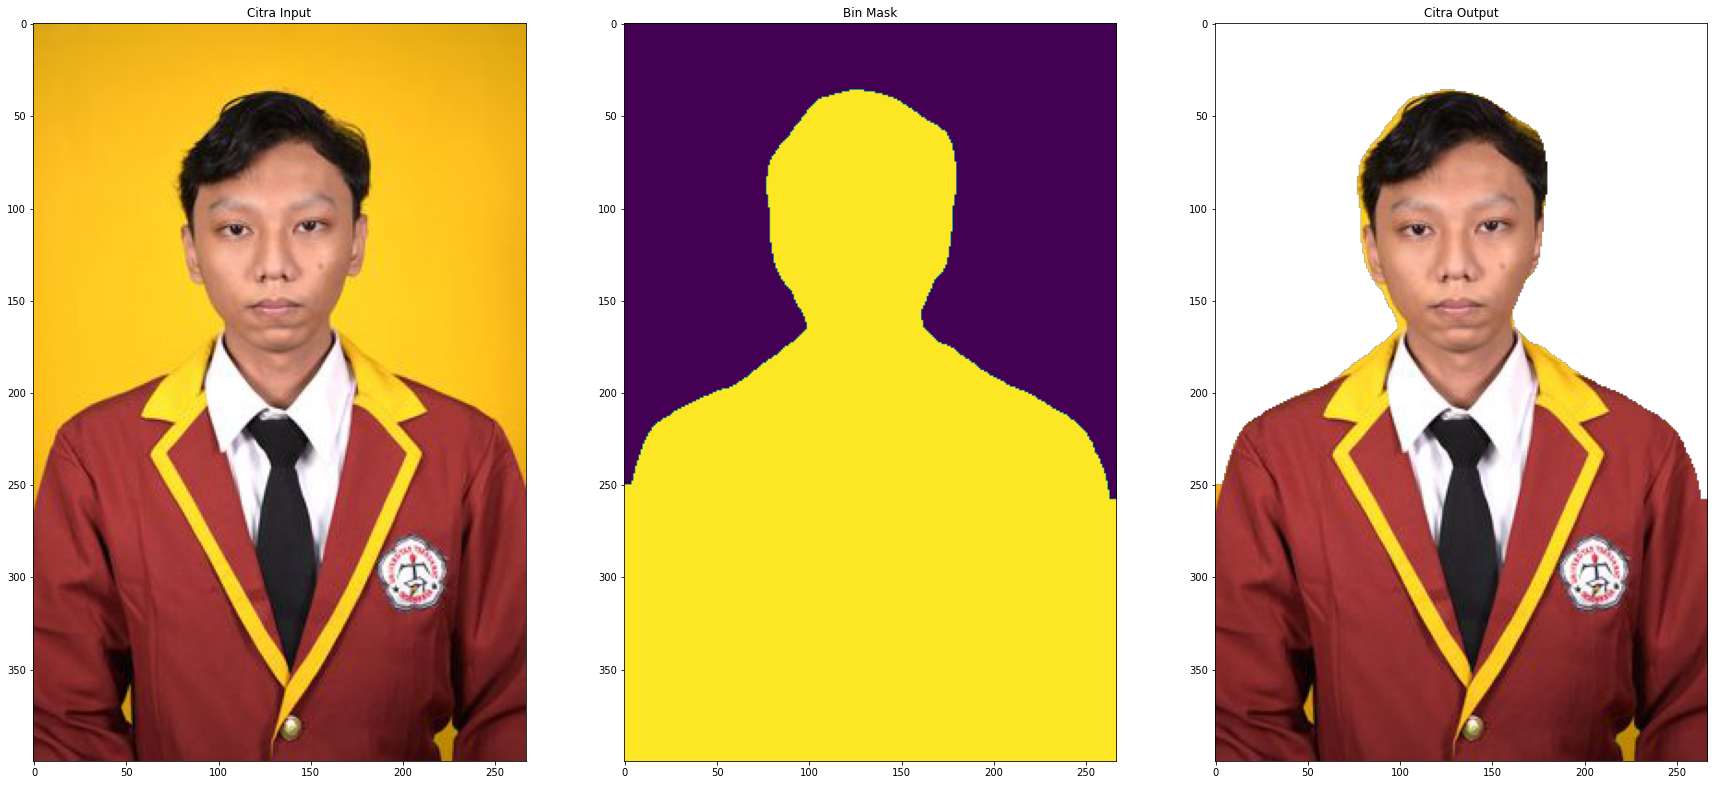

In [2]:
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# load gambar yang ada di google drive
poto = plt.imread('/content/drive/MyDrive/Colab Notebooks/PCD/poto.jpg')


# fungsi untuk load model deeplabv3_resnet101
def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

# fungsi untuk membuat background transparant, dimana fungsi ini menerima 2 paramter yaitu pic dan mask
def make_transparent_foreground(pic, mask):
  # pertama split gambar kedalam beberapa channel
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # tambahkan alpha channel dengan mengisi pixel trasnparant (maksimal 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # gabungkan alpha channel kembali
  alpha_im = cv2.merge([b, g, r, a], 4)
  # buat background tranparant
  bg = np.zeros(alpha_im.shape)
  # setup mask baru
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy warna pixel foreground dari gambar original dimana sudah di masking]
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)
  # return foreground
  return foreground

# fungsi untuk remove background menerima 2 parameter
def remove_background(model, input_file):
  # buka input image dan lakukan preproses
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  # buat input batch sesua dengan model
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  # pindahkan proses ke gpu jika ada agar mempercepat proses
  # sebagai catatan agar loading program tidak lama bisa ubah runtime type hardware accelerator dengan GPU
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # buat binary hitam dan putih sebagai masking untuk foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)
  # return foreground yang sudah jadi beserta bin_mask
  return foreground, bin_mask

# load model dengan fungsi yang sudah dibuat tadi
deeplab_model = load_model()
# remove background gambar yang dinginkan dengan mengisikan param pertama dengan model yang sudah di load
# untuk param ke dua disikan dengan path dari image
foreground, bin_mask = remove_background(deeplab_model, '/content/drive/MyDrive/Colab Notebooks/PCD/poto.jpg')

# buat sebuah figure dengan size 30 x 18 untuk memplot gambar
fig = plt.figure(figsize=(30, 18))
rows = 1
columns = 3

# plot gambar pertama dengan gammbar original
fig.add_subplot(rows, columns, 1)
plt.imshow(poto)
plt.title("Citra Input")

# plot gambar kedua dengan bin_mask
fig.add_subplot(rows, columns, 2)
plt.imshow(bin_mask)
plt.title("Bin Mask")

# plot gambar 3 dengan image background sudah di remove
fig.add_subplot(rows, columns, 3)
plt.imshow(foreground)
plt.title("Citra Output")

Langkah langkah yang terjadi :


1.   eksekusi fungsi load_model() untuk donwload model
2.   panggil fungsi remove_background() dengan input model dan input gambar
3.   fungsi tadi mengembalikan 2 numpy array yaitu foreground dan juga bin_mask
4.   foreground merupakan gambar objek yang sudah di remove backgroundnya, sedangkan bin_mask adalah binary yang terdeteksi oleh model yang digunakan
5.   tampilkan gambar dengan cara ploting ke figure ukuran 30 x 18, 1 bari 3 kolom

Kesimpulannya masalah berhasil terpecahkan dimana background berhasil diremove menggunakan bantuan sebuah model yaitu DeepLabV3-ResNet101 dari torchub. Model ini dapat membantu kita melakukan deteksi binary masking dan tidak perlu membuat model sendiri serta melatihnya.